In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import h5py
import pickle
import pandas
import matplotlib.pyplot as plt
#import deepdish.io as io
import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Input, Dense, Dropout
from keras.utils import plot_model
from keras.models import load_model
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
# Loading one of Taoli's Model
vae = load_model('VAE-FCN-model-d80-UdeMdata-cycannealing-eps1.h5', compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  63188     
_________________________________________________________________
decoder (Model)              (None, 80)                62608     
Total params: 125,796
Trainable params: 125,796
Non-trainable params: 0
_________________________________________________________________


In [4]:
encoder = load_model('/home/zp/gupta/jetAnomaly/utils/VAE-FCN-model-d80-UdeMdata-cycannealing-eps1_encoder.h5')

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  63188     
Total params: 63,188
Trainable params: 63,188
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Loading QCD sample to use jet_pT for pT scaling
fqcd=h5py.File('/home/zp/gupta/jetAnomaly/utils/qcd_pt_scaled.h5','r')

In [8]:
list(fqcd.keys())

['table']

In [9]:
qcd_train_bkg = fqcd['table']

In [10]:
qcd_train_bkg.shape

(705643, 868)

In [11]:
# Taking only 80 features to match with the model
qcd_train_bkg=qcd_train_bkg[:,:80]


In [12]:
qcd_train_bkg.shape

(705643, 80)

In [13]:
# Loading ttbar sample to use jet_pT for pT scaling
fttbar=h5py.File('/home/zp/gupta/jetAnomaly/utils/ttbar_pt_scaled.h5','r')
ttbar_pt_scaled = fttbar['table']
ttbar_pt_scaled.shape

(320124, 888)

In [14]:
ttbar_pt_scaled = ttbar_pt_scaled[:,:80]
ttbar_pt_scaled.shape

(320124, 80)

In [15]:
x_train_0 = qcd_train_bkg
x_train_1 = ttbar_pt_scaled
x_train = np.concatenate((x_train_0, x_train_1), axis=0)
y_train = np.concatenate((np.zeros(len(x_train_0)), np.ones(len(x_train_1))), axis=0)

In [16]:
x_train.shape

(1025767, 80)

In [17]:
rng = check_random_state(1)
indices = rng.permutation(len(x_train))

In [18]:
x_train_mix = [x_train[j] for j in indices[:1025700]]
y_train_mix = [y_train[j] for j in indices[:1025700]]

In [19]:
# separating train and test set
x_train_mix, x_test_mix, y_train_mix, y_test_mix = train_test_split(x_train_mix,y_train_mix,
                                                                   test_size=0.3, 
                                                                   random_state=13)

In [20]:
# separating train and test set
x_train_mix, valid_x_train_mix, y_train_mix, valid_y_train_mix = train_test_split(x_train_mix,y_train_mix,
                                                                   test_size=0.3, 
                                                                   random_state=13)

In [21]:
print("train: ",len(x_train_mix))
print("valid: ",len(valid_x_train_mix))
print("test: ",len(x_test_mix))

train:  502593
valid:  215397
test:  307710


In [22]:
x_train_mix = x_train_mix[:502500] 
y_train_mix = y_train_mix[:502500] 
valid_x_train_mix = valid_x_train_mix[:215300] 
valid_y_train_mix = valid_y_train_mix[:215300] 
x_test_mix = x_test_mix[:307700]
y_test_mix = y_test_mix[:307700]

In [23]:
print("train: ",len(x_train_mix))
print("valid: ",len(valid_x_train_mix))
print("test: ",len(x_test_mix))

train:  502500
valid:  215300
test:  307700


In [24]:
scaler= RobustScaler().fit(x_train_mix)

In [25]:
fqcd.close()
fttbar.close()

In [26]:
x_train_mix=scaler.transform(x_train_mix)
valid_x_train_mix=scaler.transform(valid_x_train_mix)
x_test_mix=scaler.transform(x_test_mix)

In [27]:
encoded_x_train = encoder.predict(x_train_mix, batch_size=100)
encoded_valid_x_train = encoder.predict(valid_x_train_mix, batch_size=100)
encoded_x_test = encoder.predict(x_test_mix, batch_size=100)

In [56]:
encoded_x_train = np.array(encoded_x_train)
encoded_valid_x_train = np.array(encoded_valid_x_train)
encoded_x_test = np.array(encoded_x_test)

In [57]:
encoded_x_train = encoded_x_train[-1]
encoded_valid_x_train = encoded_valid_x_train[-1]
encoded_x_test = encoded_x_test[-1]

In [58]:
## Binary Classifier
seqModel = Sequential()
seqModel.add(Dense(64, input_dim=10, activation= 'relu'))
seqModel.add(Dense(32, activation= 'relu'))
seqModel.add(Dense(16, activation= 'relu'))
seqModel.add(Dense(8, activation= 'relu'))
seqModel.add(Dense(1, activation= 'sigmoid'))
seqModel.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])


In [59]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8)

history=seqModel.fit(encoded_x_train, y_train_mix, epochs=100,
               batch_size=100,
               shuffle='batch',
               validation_data=(encoded_valid_x_train, valid_y_train_mix),
               callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 502500 samples, validate on 215300 samples
Epoch 1/100
502500/502500 [==============================] - 34s 68us/step - loss: 0.5686 - acc: 0.7092 - val_loss: 0.5659 - val_acc: 0.7139
Epoch 2/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5649 - acc: 0.7124 - val_loss: 0.5636 - val_acc: 0.7149
Epoch 3/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5636 - acc: 0.7135 - val_loss: 0.5633 - val_acc: 0.7152
Epoch 4/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5630 - acc: 0.7148 - val_loss: 0.5637 - val_acc: 0.7147
Epoch 5/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5626 - acc: 0.7153 - val_loss: 0.5623 - val_acc: 0.7157
Epoch 6/100
502500/502500 [==============================] - 33s 66us/step - loss: 0.5622 - acc: 0.7158 - val_loss: 0.5619 - val_acc: 0.7169
Epoch 7/100
502500/502500 [===========================

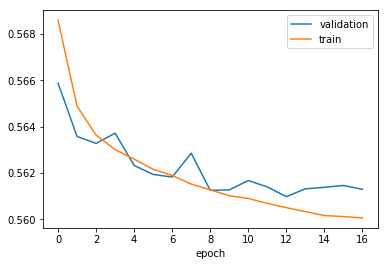

In [60]:
plt.plot(history.history['val_loss'], label='validation')
plt.plot(history.history['loss'], label='train')
#plt.title('AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [61]:
binary_truth = seqModel.predict(encoded_x_test, batch_size=100)

In [62]:
binary_truth

array([[0.21761364],
       [0.20281285],
       [0.13779566],
       ...,
       [0.05056733],
       [0.56354386],
       [0.44346488]], dtype=float32)

In [63]:
binary_truth = np.where(binary_truth<0.5, 0, binary_truth)

In [64]:
binary_truth = np.where(binary_truth!=0, 1, binary_truth)

In [65]:
binary_truth

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [66]:
predict_jets = vae.predict(x_test_mix,batch_size=100)

In [67]:
MSE_loss = np.mean(np.power(x_test_mix - predict_jets, 2), axis=1)

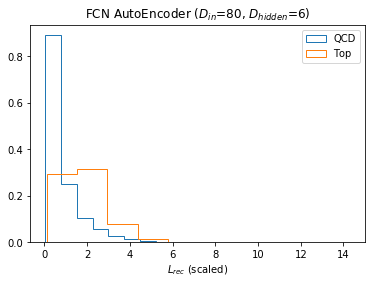

In [68]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if y_test_mix[i]==0:
        l_rec_0.append(MSE_loss[i])
    else:
        l_rec_1.append(MSE_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='QCD', density='true')
plt.hist(l_rec_1, histtype='step', label='Top', density='true')
plt.legend(loc='best')
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$L_{rec}$ (scaled)')
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.8397709350267817


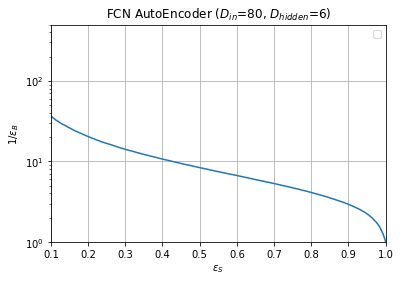

In [69]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(y_test_mix, MSE_loss)
print("roc_auc =", roc_auc_score(y_test_mix, MSE_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

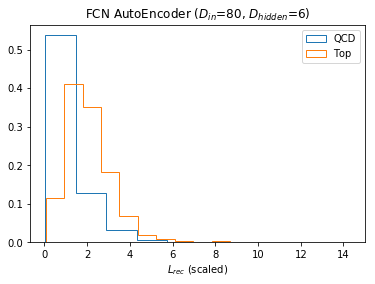

In [70]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if binary_truth[i]==0:
        l_rec_0.append(MSE_loss[i])
    else:
        l_rec_1.append(MSE_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='QCD', density='true')
plt.hist(l_rec_1, histtype='step', label='Top', density='true')
plt.legend(loc='best')
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$L_{rec}$ (scaled)')
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.8117609154662974


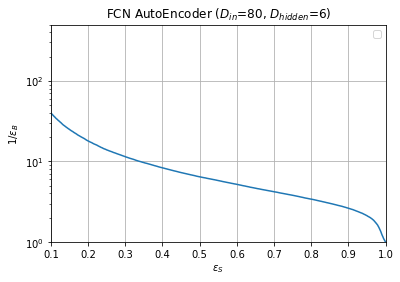

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(binary_truth, MSE_loss)
print("roc_auc =", roc_auc_score(binary_truth, MSE_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

In [73]:
seqModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [74]:
seqModel.save('/home/zp/gupta/jetAnomaly/utils/VAE-FCN-model-d80-UdeMdata-cycannealing-eps1_encodeToBinary.h5')

In [37]:
x_train_bkg = fqcd['table']
ttbar_pt_scaled = fttbar['table']

In [39]:
ttbar_pt_scaled.shape

(320124, 888)

In [69]:
x_test_mix.shape

(100000, 80)

In [70]:
# Dataset at the encoded layer
encoded_test = encoded.predict(x_test_mix, batch_size=100)
#encoded_train_bkg = encoded.predict(x_train_bkg, batch_size=100)

In [71]:
encoded_test = np.array(encoded_test)

In [72]:
encoded_test[-1].shape

(100000, 10)

In [73]:
encoded_test = encoded_test[-1]

In [74]:
x_train_bkg=scaler.transform(x_train_bkg)

In [75]:
x_train_bkg = x_train_bkg[:400000]

In [76]:
x_train_bkg.shape

(400000, 80)

In [77]:
encoded_train_bkg = encoded.predict(x_train_bkg, batch_size=100)

In [78]:
encoded_train_bkg = np.array(encoded_train_bkg)

In [79]:
encoded_train_bkg = encoded_train_bkg[-1]

In [80]:
encoded_train_bkg.shape

(400000, 10)

In [119]:
hash_size = 25
sample_size, vec_size = encoded_train_bkg.shape
projections = np.random.randn(hash_size, vec_size)

In [120]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [121]:
hashed_encoded = list()

In [122]:
for i in range(sample_size):
  bools = ''
  for j in range(hash_size):
    bool = (np.dot(encoded_train_bkg[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
    #print(bools)
  hashed_encoded.append(bools)

In [123]:
len(hashed_encoded)

400000

In [124]:
def getDuplicatesWithInfo(hashed_encoded):
    ''' Get duplicate element in a list along with thier indices in list
     and frequency count'''
    dictOfElems = dict()
    index = 0
    # Iterate over each element in list and keep track of index
    for elem in hashed_encoded:
        # If element exists in dict then keep its index in lisr & increment its frequency
        if elem in dictOfElems:
            dictOfElems[elem][0] += 1
            dictOfElems[elem][1].append(index)
        else:
            # Add a new entry in dictionary 
            dictOfElems[elem] = [1, [index]]
        index += 1    
 
    dictOfElems = { key:value for key, value in dictOfElems.items() }
    return dictOfElems

In [125]:
dictOfElems = getDuplicatesWithInfo(hashed_encoded)
listHash = list()
for key, value in dictOfElems.items():
  listHash.append(key)

In [126]:
listHash = np.array(listHash)

In [127]:
tableSize= len(listHash)

In [128]:
encoded_test.shape

(100000, 10)

In [129]:
sample_size, vec_size = encoded_test.shape

In [145]:
hash_truth = list()

In [146]:
len(hash_truth)

0

In [144]:
count = 0
for i in range(sample_size):
  bools = ''
  a = 1
  for j in range(hash_size):
    bool = (np.dot(encoded_test[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
  #print(bools)
  for k in range(tableSize):
    #print("bools: ",bools)
    #print("listHash: ", listHash[k])
    if bools == listHash[k]:
    #sim = jaccard_similarity(bools, listHash[k])
    #if sim>0.5:
      #print(sim)
      #print("listHash: ", listHash[k])
      #a=0
      print(a)
      #print(a)
      break
  #count = 0
  if(a==1):
    count+=1
    #print(a)
  #print(count)
  hash_truth.append(a)
print(count)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

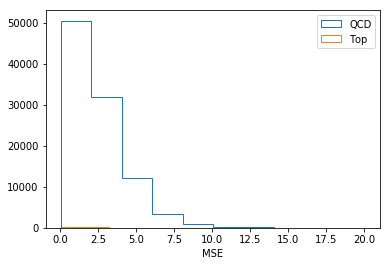

In [114]:
l_rec_0=[]
l_rec_1=[]

for i in range(100000):
    if hash_truth[i]==0:
        l_rec_0.append(MSE_loss[i])
    else:
        l_rec_1.append(MSE_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='QCD',density=False)
plt.hist(l_rec_1, histtype='step', label='Top',density=False)
plt.legend(loc='best')
plt.xlabel('MSE')
#plt.yscale("log")
plt.show()

/lcg/storage15/software64/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.43366577464752204


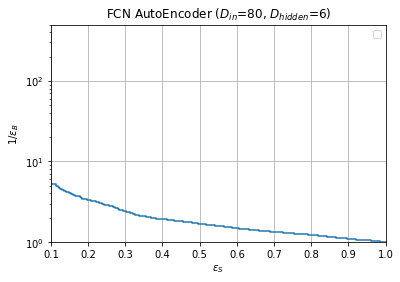

In [115]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(hash_truth, MSE_loss)
print("roc_auc =", roc_auc_score(hash_truth, MSE_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()